
### Language Intentification Model(LIM)

In this notebook we are going to create a language identification model based on the following languages.

- Zulu (zu)
- Xhosa (xh)
- Sotho (st)
- Afrikaans (af)
- English (en)
- Tsonga (ts)
___

Topic: `Sentiment Analyisis(SA) Language Identification Model (LIM).`

Date: `2022/08/24`

Programming Language: `python`

Main: `Natural Language Processing (NLP)`

___

### Model

We are going to create a model that does simple classification on single text and a list of text. At the end the model will be able to take in a sentence and identify which language does the sentence belongs to. 

In this notebook we are going to use [00_BiLSTM_PRE_TRAINED_EMBEDDING_VECTORS.ipynb](https://github.com/CrispenGari/torchtext/blob/main/sentiment-analyisis/00_BiLSTM_PRE_TRAINED_EMBEDDING_VECTORS.ipynb) as a base notebook. Which means most of the code will be taken from the referenced notebook.

### Helper Functions
We are going to use the `helperfns` package which is a python package that i've created, which contains some useful helper functions for machine learning. We need to install this package by running the following code cell.

In [1]:
!pip install helperfns -q

### Importing packages
In the following code cell we are going to import packages that we are going to use in this notebook.

In [2]:
import time
import torch
import os
import random
import torchtext
import json

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from google.colab import drive, files
from torch import nn
from torchtext import data
from collections import Counter
from torchtext import vocab
from helperfns import tables, visualization, utils
from helperfns.torch.models import model_params
from helperfns.torch.accuracy import categorical_accuracy

import torch.nn.functional as F
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

torchtext.__version__, torch.__version__

('0.13.1', '1.12.1+cu113')

### Files
Files are stored in google drive so we need to mount a google drive in our noteboook so that we can easily interact with the google file system using the `API`.

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


### File Paths
In the following code cell we are going to define the path where our files are going to be stored. We have the following filed emotion-nlpfolder that is in our google drive:

1. train.csv
2. val.csv
3. test.csv

In [4]:
base_dir = '/content/drive/My Drive/NLP Data/nmt/li_datasets'

assert os.path.exists(base_dir), f"The path '{base_dir}' does not exists, check if you have mounted the google drive."

# file names|
train_path = 'train.csv'
val_path = 'val.csv'
test_path = 'test.csv'


### Seed

We are going to set the seed for reproducivity of results in this notebook in the following code cell.

In [5]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device.

In the following code cell we are going to create a device variable and utilize the cuda `GPU` if available in this notebook.

In [6]:
device = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Reading Data

From our files that we have in google drive. We are going to read the data in these files in a pandas dataframes for all the 3 sets.

In [7]:
train_df = pd.read_csv(os.path.join(base_dir, train_path))
test_df = pd.read_csv(os.path.join(base_dir, test_path))
val_df = pd.read_csv(os.path.join(base_dir, val_path))

### Checking Examples
In the following code cell we are going to check the first 5 example using the pandas dataframe method `head` for each dataframe.

In [8]:
train_df.head()

,src,trg
0,om mee te werk en in die volgende,af
1,yi nyikele hi dragona yimbirhi ivi yi nghena e...,ts
2,e ne e le eulogy ea pele,st
3,farewell my love,en
4,__tweet t support city as hulle die enigste kl...,af


In [9]:
test_df.head()

,src,trg
0,ilungele into entsha incwadi entsha leyo inkcu...,xh
1,"as u nie daaroor grap nie, is dit nie die enig...",af
2,sports is bae,en
3,die beste speler op die veld gewees hierdie he...,af
4,_ace ek sweer s era x was fa sho action sport ...,af


In [10]:
val_df.head()

,src,trg
0,ek het niks oorweeg in my filmtelevisie nie en...,af
1,xihloko hi munghana eka ku tsakisa swinene na ...,ts
2,ulimi lweretoric lwenzelwe ukuba nomthelela ok...,zu
3,damn my own me all love tho focus eka mintlang...,ts
4,yintoni eyoyikisayo yile bokongeza kum umntu o...,xh


### Counting examples
In the following code cell we are going to count how many examples do we have in each set and visualize them in a tabular format.

In [11]:
columns = ["Set", "Example(s)"]
examples = [
    ['training', f"{len(train_df):,}"],
    ['validation', f"{len(val_df):,}"],
    ['testing', f"{len(test_df):,}"],
    ['total', f"{(len(train_df) +  len(test_df) + len(val_df)):,}"],
]
tables.tabulate_data(columns, examples, "Exmples")

+-------------------------+
|         Exmples         |
+------------+------------+
| Set        | Example(s) |
+------------+------------+
| training   |    496,766 |
| validation |     26,146 |
| testing    |     27,522 |
| total      |    550,434 |
+------------+------------+


###Features and Labels
Our fetures are the actual sentences in the dataframe which is the column named `src` and our labels will come from the column called `trg`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [12]:
# train
train_texts = train_df.src.values
train_labels = train_df.trg.values

# test
test_texts = test_df.src.values
test_labels = test_df.trg.values

# val
val_texts = val_df.src.values
val_labels = val_df.trg.values

### Text Preprocessing
In our text processing pipeline we need to do the following step:

1. tokenize text
this is the process of converting a sentence or text into senquence of word. 

2. vocabulary
We will to create a vocabulary based on our text. A vocabulary is esentially a word to index mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cel we aregoing to create a general tokenizer function. We are using a general tokenizer function that esentially slip sentences by a delimeter which is a space.

In [13]:
def tokenizer(sent: str)->list:
  return sent.split(" ")

tokenizer("This is a boy.")

['This', 'is', 'a', 'boy.']

### Vocabulary
In the following code cell we are going to create a `vocabulary` object from `torchtext`. This vocabulary takes in an `ordered_dict` of words to their count. So we are going to use the `Counter` module from collections to generate these counts from our train features.

We are going to specify the `min_freq` to 2 meaning that the words that does not appear at least 2 times will be converted to `unknown`. We are also going to specify the special tokens during creation of the vocabulary object.

In [14]:
counter = Counter()
for line in train_texts:
   counter.update(tokenizer(line))
vocabulary = vocab.vocab(counter, min_freq=2, specials=('<unk>', '<sos>', '<eos>', '<pad>'))

### STOI - String To Integer
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called `stoi` which is essentially a dictionary of word to index mapping.

In [15]:
stoi = vocabulary.get_stoi()

###Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the `text_pipeline` function will come into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay stoi will be habin an unkown (`<unk>`) index.

In [16]:
def text_pipeline(x: str):
  values = list()
  tokens = tokenizer(x.lower()) # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['<unk>']
    values.append(v)
  return values

###Label pipeline
Our labels for now are just langauge labels like `en`. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a `labels_vocab` which is a label to integer representation. Which looks as follows:

```json
{"af": 0, "ts": 1, "st": 2, "en": 3, "xh": 4, "zu": 5}
```
The `label_pipeline` function will then takes in the label and then returns us an integer representation of that label.

In [17]:
labels_dict = dict({v: k for k, v in enumerate(train_df.trg.unique())})
labels_dict

{'af': 0, 'ts': 1, 'st': 2, 'en': 3, 'xh': 4, 'zu': 5}

In [18]:
label_pipeline = lambda x: labels_dict[x]

#### Creating the LanguageIdentificationDataset
In the following code cell we are going to create a dataset class called `LanguageIdentificationDataset`. This dataset will takes in the labels and the text of a set.

In [19]:
class LanguageIdentificationDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(LanguageIdentificationDataset, self).__init__()
    self.labels = labels
    self.text = text
      
  def __getitem__(self, index):
    return self.labels[index], self.text[index]
  
  def __len__(self):
    return len(self.labels)

  def __str__(self) -> str:
    return "LanguageIdentificationDataset"

  def __repr__(self) -> str:
    return "LanguageIdentificationDataset"

### collate_fn
We are going to create a collate function called `tokenize_batch`. This function acually takes in a batch and does the preprocessing of the text and labels. This function will be passed to the `DataLoader` class to do the preprocessing of features and labels.

1. `tokenize_batch` function:

* this function takes in a batch in each set and convert the features and labels to integer representation. It goes ahead and pad and truncate the sequence to the same length and returns labels and features.

In [20]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  return torch.LongTensor(labels_list), torch.cat(text_list, dim=0)

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `LanguageIdentificationDataset` class.

In [21]:
train_dataset = LanguageIdentificationDataset(train_labels, train_texts)
test_dataset = LanguageIdentificationDataset(test_labels, test_texts)
val_dataset = LanguageIdentificationDataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the DataLoader class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `128` and our `collate_function` is `tokenize_batch`. For the validation and testing dataset we are going to set the shuffle to `False` because there's no need fo us to shuffle these examples.

In [22]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

### Checking a single Batch Data

In [23]:
lbl, txt = iter(train_loader).next()

First text example in a batch

In [24]:
txt[0]

tensor([  874,     0,  5663,     0,    85, 86722,     9,     9,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       dtype=torch.int32)

Labels in the first batch.

In [25]:
lbl

tensor([5, 4, 4, 5, 5, 0, 4, 4, 0, 5, 1, 2, 2, 0, 1, 4, 3, 2, 2, 3, 2, 1, 1, 3,
        3, 0, 1, 4, 1, 2, 0, 1, 4, 2, 1, 4, 3, 1, 4, 5, 3, 3, 2, 3, 3, 0, 5, 1,
        3, 4, 4, 3, 1, 2, 1, 4, 3, 1, 4, 1, 0, 2, 4, 3, 0, 3, 2, 0, 1, 1, 3, 0,
        2, 3, 1, 2, 1, 0, 0, 3, 4, 4, 5, 3, 5, 4, 4, 4, 3, 4, 5, 3, 0, 4, 4, 4,
        3, 5, 4, 5, 5, 5, 1, 3, 4, 4, 2, 5, 2, 1, 5, 5, 3, 1, 1, 2, 2, 3, 1, 5,
        2, 1, 1, 2, 0, 0, 1, 2])

### Model Creation
Now that we have our loaders we can now create a model. The model that we are going to create is called `LanguageIdentificationModel`. In the following code cell we are going to create our model.

In [26]:
class LanguageIdentificationModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers
               , bidirectional, dropout, pad_idx):
    super(LanguageIdentificationModel, self).__init__()

    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim=embedding_size, padding_idx=pad_idx),
        nn.Dropout(dropout)
    )
    self.lstm = nn.Sequential(
        nn.LSTM(
          embedding_size, 
          hidden_size=hidden_size, 
          bidirectional=bidirectional, 
          num_layers=num_layers,
          dropout=dropout
        )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=128),
        nn.Dropout(dropout),
        nn.Linear(128, out_features=output_size),
        nn.Dropout(dropout)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
    packed_output, (h_0, c_0) = self.lstm(packed_embedded)
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    output = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim = 1)
    return self.out(output)

### Model Instance
In the following code cell we are going to create a model instance.

In [27]:
INPUT_DIM = len(stoi) 
EMBEDDING_DIM = 1000
HIDDEN_DIM = 256
OUTPUT_DIM = len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['<pad>'] 
li_model = LanguageIdentificationModel(
              INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM, 
              N_LAYERS, 
              BIDIRECTIONAL, 
              DROPOUT, 
              PAD_IDX
).to(device)
li_model

LanguageIdentificationModel(
  (embedding): Sequential(
    (0): Embedding(154060, 1000, padding_idx=3)
    (1): Dropout(p=0.5, inplace=False)
  )
  (lstm): Sequential(
    (0): LSTM(1000, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=6, bias=True)
    (3): Dropout(p=0.5, inplace=False)
  )
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters. We are going to use the `model_params` function from `helperfns.torch.models`

In [28]:
model_params(li_model)

TOTAL MODEL PARAMETERS: 	158,279,782
TOTAL TRAINABLE PARAMETERS: 	158,279,782


### Optimizer and Criterion
In the following code cell we are going to define the optimizer and criterion. For the optimizer we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a `multi-class` classification.

In [29]:
optimizer = torch.optim.Adam(li_model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalutate` functions:

In [30]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()
    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop
In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased.

In [31]:
N_EPOCHS = 10
MODEL_NAME = 'li-model.pt'

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(li_model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(li_model, val_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(li_model.state_dict(), MODEL_NAME)
  end = time.time()
  data = [
       ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{utils.hms_string(end - start)}" ],
       ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],       
   ]
  columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
  tables.tabulate_data(columns, data, title)

+--------------------------------------------+
|     EPOCH: 01/10 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.718 |    0.638 | 0:10:55.59 |
| Validation | 0.082 |    0.974 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 02/10 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.666 |    0.650 | 0:11:05.56 |
| Validation | 0.071 |    0.978 |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|     EPOCH: 03/10 saving best model...      |
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [32]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
li_model.load_state_dict(torch.load(MODEL_NAME))
test_loss, test_acc = evaluate(li_model, test_loader, criterion)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tables.tabulate_data(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.058 |   98.35% |            |
+------+-------+----------+------------+


### Model Inference
In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [33]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with <pad> = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

### Types

In the following code cell we are going to create data-classes for our predictions types which are:

1. `Language`
2. `PredictionResponse`
3. `LanguageIdentificationPredictionResponse`
4. `LanguageIdentificationPredictionResponseWrapper`

In [34]:
class Language:
  langs = {'af': "Afrikaans", 'ts': "Tswana", 'st': "Sotho", 'en': "English", 'xh': "Xhosa", 'zu': "Zulu"}
  def __init__(self, id:int, code: str) -> None:
    self.id = id
    self.code = code
    self.name = Language.langs.get(code)

  def __str__(self) -> str:
    return f"<Language: {self.name}({self.code})>"

  def __repr__(self)->str:
    return f"<Language: {self.name}({self.code})>"

  def to_json(self):
    return {
        'id': self.id,
        'code': self.code,
        'name': self.name
    }

class PredictionResponse:
  def __init__(self, language:Language, probability: float):
    self.language = language
    self.probability = probability

  def __str__(self) -> str:
    return f"{self.language.name} ({self.language.code})"

  def __repr__(self) -> str:
    return f"{self.language.name} ({self.language.code})"

  def to_json(self):
    return {
        'language': self.language.to_json(),
        'probability': self.probability,
    }

class LanguageIdentificationPredictionResponse:
  def __init__(self, prediction:PredictionResponse, all: list, sent: str):
    self.prediction = prediction
    self.all = all

  def __str__(self) -> str:
    return f"LanguageIdentificationPredictionResponse"

  def __repr__(self) -> str:
    return f"LanguageIdentificationPredictionResponse"

  def to_json(self):
    return {
        'prediction': self.prediction.to_json(),
        'all': self.all
    }

class LanguageIdentificationPredictionResponseWrapper:
  def __init__(self, response:LanguageIdentificationPredictionResponse, total: int=1, multiple:bool = True, eta:int =0):
    self.response = response
    self.multiple = multiple
    self.total = total
    self.eta = eta

  def __str__(self) -> str:
    return f"LanguageIdentificationPredictionResponseWrapper"

  def __repr__(self) -> str:
    return f"LanguageIdentificationPredictionResponseWrapper"

  def to_json(self):
    return {
      "response": self.response if  isinstance(self.response, list) else self.response.to_json(),
      "meta":{
          'multiple': self.multiple,
          'total': self.total,
          'eta': self.eta
      }
    }


When making predictions user can give us one or more sentences and the model will be able to identify which language the `text` belongs to.

In [35]:
classes = {v:k for k, v in labels_dict.items()}
def predict(tensors, lengths, model, user_input):
  if len(tensors.shape) == 2:
    start = time.time()
    probabilities = torch.softmax(model(tensors, lengths), dim=1).squeeze().detach().cpu().numpy()
    pred = np.argmax(probabilities)
    probability = float(probabilities[pred])
    code = classes[pred]
    prediction = PredictionResponse(Language(pred, code), round(probability, 2)) 
    all = [PredictionResponse(Language(i, classes[i]), round(prob, 2)).to_json() for i, prob in enumerate(probabilities)]
    pred_response = LanguageIdentificationPredictionResponse(prediction, all, user_input)
    end = time.time()
    return LanguageIdentificationPredictionResponseWrapper(pred_response, multiple=False, eta=end-start).to_json()
  else:
    preds = []
    start = time.time()
    for length, tensor, sent in zip(lengths, tensors, user_input):
      probabilities = torch.softmax(model(tensor, length), dim=1).squeeze().detach().cpu().numpy()
      pred = np.argmax(probabilities)
      probability = float(probabilities[pred])
      code = classes[pred]
      prediction = PredictionResponse(Language(pred, code), round(probability, 2)) 
      all = [PredictionResponse(Language(i, classes[i]), round(prob, 2)).to_json() for i, prob in enumerate(probabilities)]

      pred_response = LanguageIdentificationPredictionResponse(prediction, all, sent)
      preds.append(pred_response.to_json())
    end = time.time()
    return LanguageIdentificationPredictionResponseWrapper(preds, multiple=True, eta=end-start, total=len(user_input)).to_json()

def indentify_language(model, user_input):
  model.eval()
  with torch.no_grad():
    assert isinstance(user_input, list) or isinstance(user_input, str), "The user input can be a list of sentences or a single sentence."
    if isinstance(user_input, list):
      tensors = torch.from_numpy(
          np.array([inference_preprocess_text(sent).numpy() for sent in user_input])
      ).to(device)
      lengths = torch.LongTensor([len(t) for t in tensors]).unsqueeze(1)
      return predict(tensors, lengths, model, user_input)
    else:
      tensors = inference_preprocess_text(user_input).to(device)
      lengths = torch.LongTensor([len(t) for t in tensors])
      return predict(tensors, lengths, model, user_input)
indentify_language(li_model, ["this", "molo", "sanibonani"])

{'response': [{'prediction': {'language': {'id': 3,
     'code': 'en',
     'name': 'English'},
    'probability': 0.76},
   'all': [{'language': {'id': 0, 'code': 'af', 'name': 'Afrikaans'},
     'probability': 0.03},
    {'language': {'id': 1, 'code': 'ts', 'name': 'Tswana'},
     'probability': 0.03},
    {'language': {'id': 2, 'code': 'st', 'name': 'Sotho'},
     'probability': 0.02},
    {'language': {'id': 3, 'code': 'en', 'name': 'English'},
     'probability': 0.76},
    {'language': {'id': 4, 'code': 'xh', 'name': 'Xhosa'},
     'probability': 0.01},
    {'language': {'id': 5, 'code': 'zu', 'name': 'Zulu'},
     'probability': 0.15}]},
  {'prediction': {'language': {'id': 4, 'code': 'xh', 'name': 'Xhosa'},
    'probability': 1.0},
   'all': [{'language': {'id': 0, 'code': 'af', 'name': 'Afrikaans'},
     'probability': 0.0},
    {'language': {'id': 1, 'code': 'ts', 'name': 'Tswana'},
     'probability': 0.0},
    {'language': {'id': 2, 'code': 'st', 'name': 'Sotho'}, 'probabil

In [36]:
indentify_language(li_model, "this is me.")

{'response': {'prediction': {'language': {'id': 3,
    'code': 'en',
    'name': 'English'},
   'probability': 0.95},
  'all': [{'language': {'id': 0, 'code': 'af', 'name': 'Afrikaans'},
    'probability': 0.02},
   {'language': {'id': 1, 'code': 'ts', 'name': 'Tswana'},
    'probability': 0.01},
   {'language': {'id': 2, 'code': 'st', 'name': 'Sotho'}, 'probability': 0.01},
   {'language': {'id': 3, 'code': 'en', 'name': 'English'},
    'probability': 0.95},
   {'language': {'id': 4, 'code': 'xh', 'name': 'Xhosa'}, 'probability': 0.01},
   {'language': {'id': 5, 'code': 'zu', 'name': 'Zulu'},
    'probability': 0.01}]},
 'meta': {'multiple': False, 'total': 1, 'eta': 0.007153749465942383}}

### Confusion matrix.
In the following code cell we are going to extract features and labels in the `test` dataset and use them to evaluate the best model. We are going to plot the `confusion_matrix`.

In [51]:
test_features = []
test_labels = []
for (y, X) in test_loader:
  test_features.extend(X.numpy())
  test_labels.extend(y.numpy())
test_features = torch.tensor([i for i in test_features])

Getting predictions

In [58]:
lengths = torch.tensor([len(i) for i in test_features])
li_model.eval()
preds = list()
with torch.no_grad():
  for length, feature in zip(lengths,test_features):
    feature = torch.tensor([feature.detach().cpu().numpy()]).to(device)
    length = torch.tensor([length.item()])
    pred = torch.argmax(li_model(feature, length), dim=1).squeeze().cpu().item()
    preds.append(pred)

Getting the class names.

In [59]:
classes_names = [k for k, v in labels_dict.items()]
classes_names

['af', 'ts', 'st', 'en', 'xh', 'zu']

In the next code cell we are going to plot the confusion matrix. 

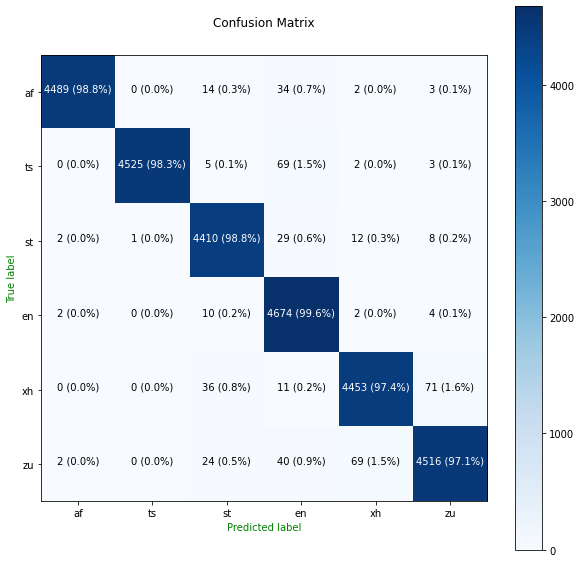

In [63]:
visualization.plot_complicated_confusion_matrix(test_labels, preds, classes_names, figsize=(10, 10), fontsize=10)

### Downloading Model

In the following code cell we are going to download the best model as a static file.

In [61]:
files.download(MODEL_NAME)

print("Done!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done!


### Downloading Files

In the following code cell we are going to create a `vocab.json` file and a `labels.json` file. Then we will download these files because our model inference process depend on the data that is in the `stoi` and `labels_dict` objects.

In [62]:
with open('vocab.json', 'w') as writer:
  writer.write(json.dumps(stoi, indent=2))

with open('labels_dict.json', 'w') as writer:
  writer.write(json.dumps(labels_dict, indent=2))

files.download('vocab.json')
files.download('labels_dict.json')

print("Done!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done!


### Classification Report

In the following code cell we are going to display the classification report for our model on the test examples.

In [74]:
cr = classification_report(
     np.array(test_labels), 
     np.array(preds),
     target_names=np.array(classes_names), 
)
print(cr)

              precision    recall  f1-score   support

          af       1.00      0.99      0.99      4542
          ts       1.00      0.98      0.99      4604
          st       0.98      0.99      0.98      4462
          en       0.96      1.00      0.98      4692
          xh       0.98      0.97      0.98      4571
          zu       0.98      0.97      0.98      4651

    accuracy                           0.98     27522
   macro avg       0.98      0.98      0.98     27522
weighted avg       0.98      0.98      0.98     27522

